# Could we find genes correlate with Rostal-Caudal axis?

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/")
os.chdir(root_dir / "L4_IT")
plot_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/L4_IT/figures/")

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import scanpy as sc
import decoupler as dc
import numpy as np
import scipy.stats as stats
import seaborn as sns

## RNA (correlation with order along the axis)

In [3]:
L4_IT_rna = sc.read_h5ad("L4_IT_rna_matrix.h5ad")
L4_IT_rna_counts = L4_IT_rna.raw.to_adata()

In [4]:
L4_IT_rna_region_counts = dc.get_pseudobulk(
    adata=L4_IT_rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)

In [5]:
sc.pp.normalize_total(L4_IT_rna_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_rna_region_counts, base=2)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
data_matrix = L4_IT_rna_region_counts[region_align, :].X

In [7]:
import scipy.stats as stats

In [8]:
b = np.arange(0, len(region_align))
corrs = np.zeros(data_matrix.shape[1])
pvalues = np.zeros(data_matrix.shape[1])

for i in range(0, data_matrix.shape[1]):
    a = data_matrix[:, i]
    corr, pvalue = stats.spearmanr(a, b)
    corrs[i] = corr
    pvalues[i] = pvalue

In [9]:
padjusted = stats.false_discovery_control(pvalues, method="bh")

In [10]:
spearman_result = pd.DataFrame({
    "gene": L4_IT_rna_region_counts.var.index.to_list(),
    "corr": corrs,
    "p_value": pvalues,
    "p_adjusted": padjusted,
})

In [11]:
spearman_result.to_csv(
    "L4_IT_rostral_caudal_spearman_corr.tsv", sep="\t", header=True, index=False)

In [12]:
spearman_sig_positive = spearman_result[
    (spearman_result["p_adjusted"] < 0.01) & (spearman_result["corr"] > 0)]
spearman_sig_negative = spearman_result[
    (spearman_result["p_adjusted"] < 0.01) & (spearman_result["corr"] < 0)]

In [13]:
positive_sig_genes = spearman_sig_positive["gene"].to_list()
positive_matrix = L4_IT_rna_region_counts[region_align, positive_sig_genes].X

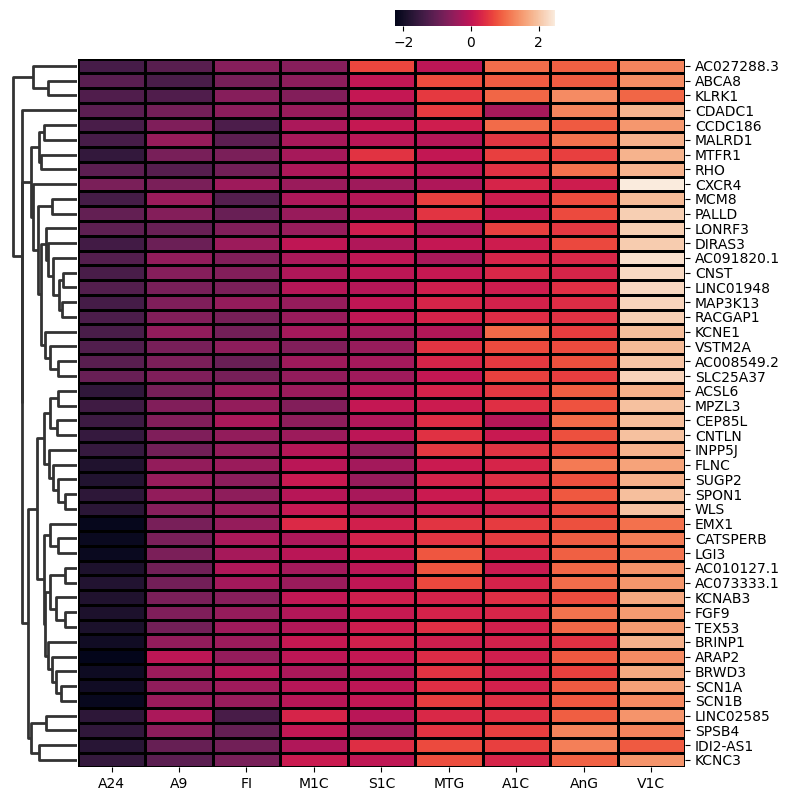

In [14]:
sns.clustermap(
    positive_matrix.T,
    xticklabels=region_align,
    yticklabels=positive_sig_genes,
    z_score="row",
    figsize=(8, 8),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=2,
    linecolor="black",
)

In [15]:
negative_sig_genes = spearman_sig_negative["gene"].to_list()
negative_matrix = L4_IT_rna_region_counts[region_align, negative_sig_genes].X

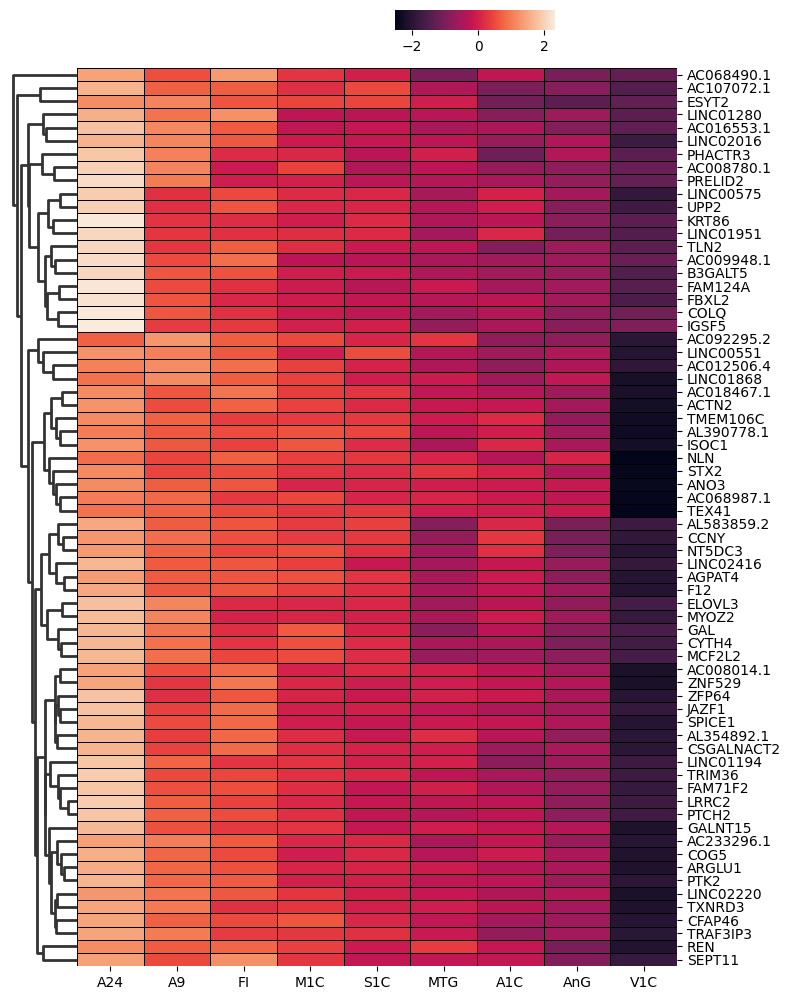

In [16]:
sns.clustermap(
    negative_matrix.T,
    xticklabels=region_align,
    yticklabels=negative_sig_genes,
    z_score="row",
    figsize=(8, 10),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=0.5,
    linecolor="black",
)

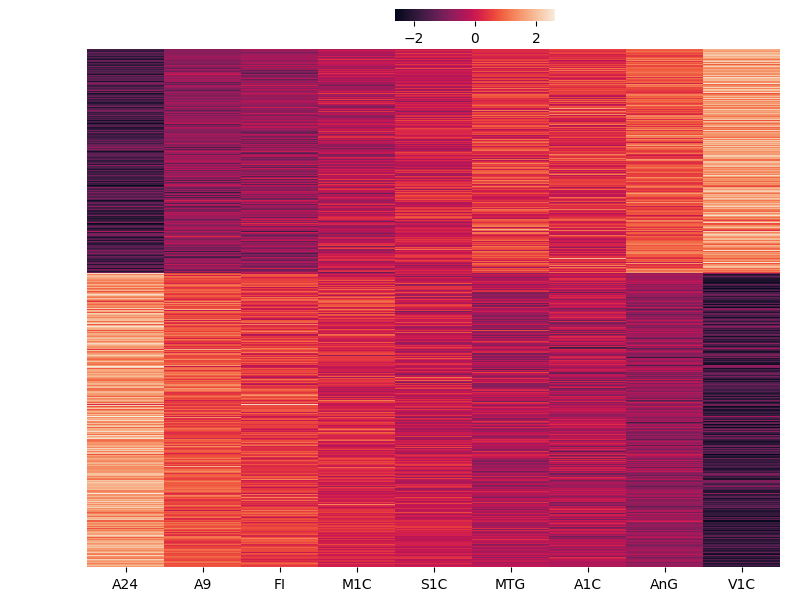

In [17]:
full_gene = spearman_result[spearman_result["p_adjusted"] < 0.05].sort_values(
    by="corr", ascending=False)["gene"]
full_sorted_matrix = L4_IT_rna_region_counts[region_align, full_gene].X
fig = sns.clustermap(
    full_sorted_matrix.T,
    xticklabels=region_align,
    yticklabels=[],
    z_score="row",
    figsize=(8, 6),
    col_cluster=False,
    row_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    # tree_kws={"linewidth": 2},
    # linewidth=0.5,
    # linecolor="black",
)
fig.savefig(plot_dir / "L4_IT_rostral_caudal_corr_RNA.png", dpi=300, format="png")

In [18]:
positive_sig_genes = spearman_result[
    (spearman_result["corr"] > 0) & (spearman_result["p_adjusted"] < 0.01)]["gene"].to_list()
with open("rostral_caudal_spearman/positive_genes_bh_1e-2.tsv", "w") as fout:
    for gene in positive_sig_genes:
        fout.write("{}\n".format(gene))

positive_sig_genes = spearman_result[
    (spearman_result["corr"] > 0) & (spearman_result["p_adjusted"] < 0.05)]["gene"].to_list()
with open("rostral_caudal_spearman/positive_genes_bh_5e-2.tsv", "w") as fout:
    for gene in positive_sig_genes:
        fout.write("{}\n".format(gene))

In [19]:
negative_sig_genes = spearman_result[
    (spearman_result["corr"] < 0) & (spearman_result["p_adjusted"] < 0.01)]["gene"].to_list()
with open("rostral_caudal_spearman/negative_genes_bh_1e-2.tsv", "w") as fout:
    for gene in negative_sig_genes:
        fout.write("{}\n".format(gene))

negative_sig_genes = spearman_result[
    (spearman_result["corr"] < 0) & (spearman_result["p_adjusted"] < 0.05)]["gene"].to_list()
with open("rostral_caudal_spearman/negative_genes_bh_5e-2.tsv", "w") as fout:
    for gene in negative_sig_genes:
        fout.write("{}\n".format(gene))

In [20]:
with open("rostral_caudal_spearman/full_gene_list.tsv", "w") as fout:
    for gene in full_gene:
        fout.write("{}\n".format(gene))

## RNA (correlation with percent of cells)

In [3]:
prop_table = pd.read_csv(
    "../all/BICCN_all_regional_donor_subclass_proportion.tsv",
    sep="\t", header=0
)

In [4]:
L4_IT_prop_table = prop_table[prop_table["Subclass_F"] == "L4 IT"]
L4_IT_prop_table["Donor_Region"] = \
    L4_IT_prop_table["PatientID"].astype("str") + "_" + L4_IT_prop_table["Region"].astype("str")
L4_IT_prop_table.set_index("Donor_Region", inplace=True)

In [5]:
L4_IT_rna = sc.read_h5ad("L4_IT_rna_matrix.h5ad")
L4_IT_rna_counts = L4_IT_rna.raw.to_adata()

In [6]:
L4_IT_rna_counts.obs["Donor_Region"] = \
    L4_IT_rna_counts.obs["PatientID"].astype("str") + "_" + L4_IT_rna_counts.obs["Region"].astype("str")

In [7]:
L4_IT_rna_region_counts = dc.get_pseudobulk(
    adata=L4_IT_rna_counts,
    sample_col="Donor_Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)

In [8]:
sc.pp.normalize_total(L4_IT_rna_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_rna_region_counts, base=2)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
b = L4_IT_prop_table.loc[L4_IT_rna_region_counts.obs.index, "prop"].to_list()
corrs = np.zeros(L4_IT_rna_region_counts.shape[1])
pvalues = np.zeros(L4_IT_rna_region_counts.shape[1])

for i in range(0, L4_IT_rna_region_counts.shape[1]):
    a = L4_IT_rna_region_counts.X[:, i]
    corr, pvalue = stats.pearsonr(a, b)
    corrs[i] = corr
    pvalues[i] = pvalue

In [10]:
padjusted = stats.false_discovery_control(pvalues, method="bh")

In [11]:
pearson_result = pd.DataFrame({
    "gene": L4_IT_rna_region_counts.var.index.to_list(),
    "corr": corrs,
    "p_value": pvalues,
    "p_adjusted": padjusted,
})

In [12]:
pearson_sig_positive = pearson_result[
    (pearson_result["p_adjusted"] < 0.01) & (pearson_result["corr"] > 0.7)]
pearson_sig_negative = pearson_result[
    (pearson_result["p_adjusted"] < 0.01) & (pearson_result["corr"] < -0.7)]

In [13]:
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]

In [14]:
L4_IT_rna_region_counts.obs["Region"] = pd.Categorical(
    L4_IT_rna_region_counts.obs["Region"], categories=region_align)

In [15]:
x_index = L4_IT_rna_region_counts.obs.sort_values(by=["Region", "PatientID"]).index

<AxesSubplot: >

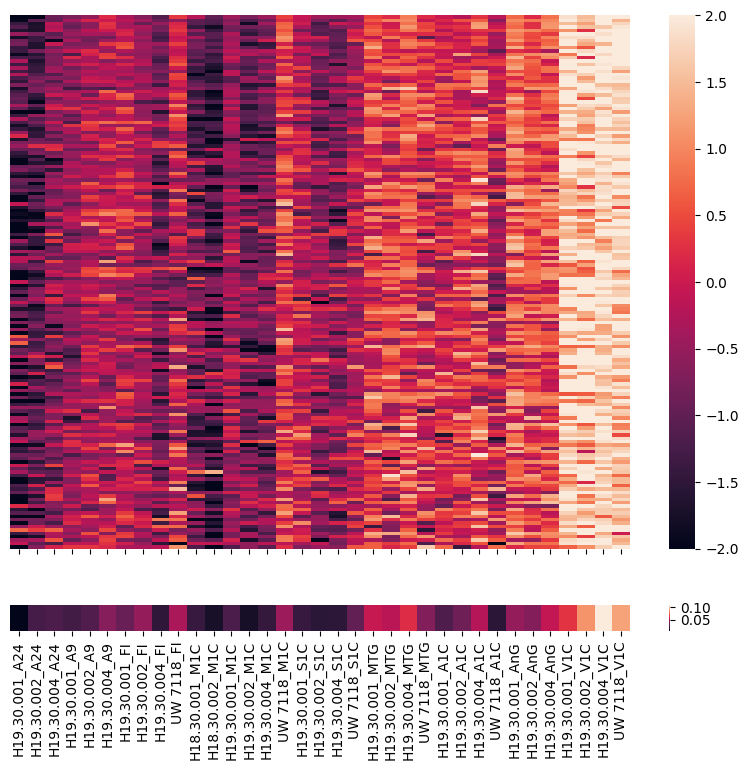

In [16]:
fig, axs = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={"height_ratios": [20, 1]}
)
fig.set_figwidth(10)
fig.set_figheight(8)
plot_matrix = L4_IT_rna_region_counts[
    x_index, pearson_sig_positive.sort_values(by="corr", ascending=False)["gene"]].X.T.copy()
plot_mean = np.mean(plot_matrix, axis=1, keepdims=True)
plot_std = np.std(plot_matrix, axis=1, keepdims=True)
plot_matrix = (plot_matrix - plot_mean) / plot_std
sns.heatmap(
    plot_matrix,
    ax=axs[0],
    yticklabels=[],
    vmin=-2,
    vmax=2
)
sns.heatmap(
    L4_IT_prop_table.loc[x_index, "prop"].to_numpy()[np.newaxis, :], 
    ax=axs[1],
    xticklabels=x_index.to_list(),
    yticklabels=[]
)

In [17]:
positive_sig_genes = pearson_result[
    (pearson_result["corr"] > 0.7) & (pearson_result["p_adjusted"] < 0.01)]["gene"].to_list()
with open("rostral_caudal_pearson_prop_cells//positive_genes_bh_7e-1_1e-2.tsv", "w") as fout:
    for gene in positive_sig_genes:
        fout.write("{}\n".format(gene))

In [18]:
negative_sig_genes = pearson_result[
    (pearson_result["corr"] < -0.7) & (pearson_result["p_adjusted"] < 0.01)]["gene"].to_list()
with open("rostral_caudal_pearson_prop_cells//negative_genes_bh_7e-1_1e-2.tsv", "w") as fout:
    for gene in negative_sig_genes:
        fout.write("{}\n".format(gene))

In [19]:
pearson_result.to_csv(
    "L4_IT_rostral_caudal_pearson_prop_cells.tsv", sep="\t", header=True, index=False)

## RNA spearman /  donor as replicates

In [3]:
L4_IT_rna = sc.read_h5ad("L4_IT_rna_matrix.h5ad")
L4_IT_rna_counts = L4_IT_rna.raw.to_adata()

In [4]:
L4_IT_rna_counts.obs["Donor_Region"] = \
    L4_IT_rna_counts.obs["PatientID"].astype("str") + "_" + L4_IT_rna_counts.obs["Region"].astype("str")

In [5]:
L4_IT_rna_region_counts = dc.get_pseudobulk(
    adata=L4_IT_rna_counts,
    sample_col="Donor_Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)

In [6]:
sc.pp.normalize_total(L4_IT_rna_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_rna_region_counts, base=2)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
L4_IT_rna_region_counts.obs["Region"] = pd.Categorical(
    L4_IT_rna_region_counts.obs["Region"], categories=region_align
)

In [8]:
sorted_index = L4_IT_rna_region_counts.obs.sort_values(by="Region").index

In [9]:
b = L4_IT_rna_region_counts.obs.loc[sorted_index, "Region"].cat.codes.to_list()
data_matrix = L4_IT_rna_region_counts[sorted_index, :].X
corrs = np.zeros(data_matrix.shape[1])
pvalues = np.zeros(data_matrix.shape[1])

for i in range(0, data_matrix.shape[1]):
    a = data_matrix[:, i]
    corr, pvalue = stats.spearmanr(a, b)
    corrs[i] = corr
    pvalues[i] = pvalue

In [10]:
padjusted = stats.false_discovery_control(pvalues, method="bh")

In [11]:
spearman_result = pd.DataFrame({
    "gene": L4_IT_rna_region_counts.var.index.to_list(),
    "corr": corrs,
    "p_value": pvalues,
    "p_adjusted": padjusted,
})

In [12]:
spearman_result.to_csv(
    "L4_IT_rostral_caudal_spearman_corr_with_donor_replicates.tsv", sep="\t", header=True, index=False)

In [13]:
spearman_sig_positive = spearman_result[
    (spearman_result["p_adjusted"] < 0.01) & (spearman_result["corr"] > 0.75)]
spearman_sig_negative = spearman_result[
    (spearman_result["p_adjusted"] < 0.01) & (spearman_result["corr"] < -0.75)]

In [14]:
positive_sig_genes = spearman_sig_positive["gene"].to_list()
positive_matrix = L4_IT_rna_region_counts[sorted_index, positive_sig_genes].X

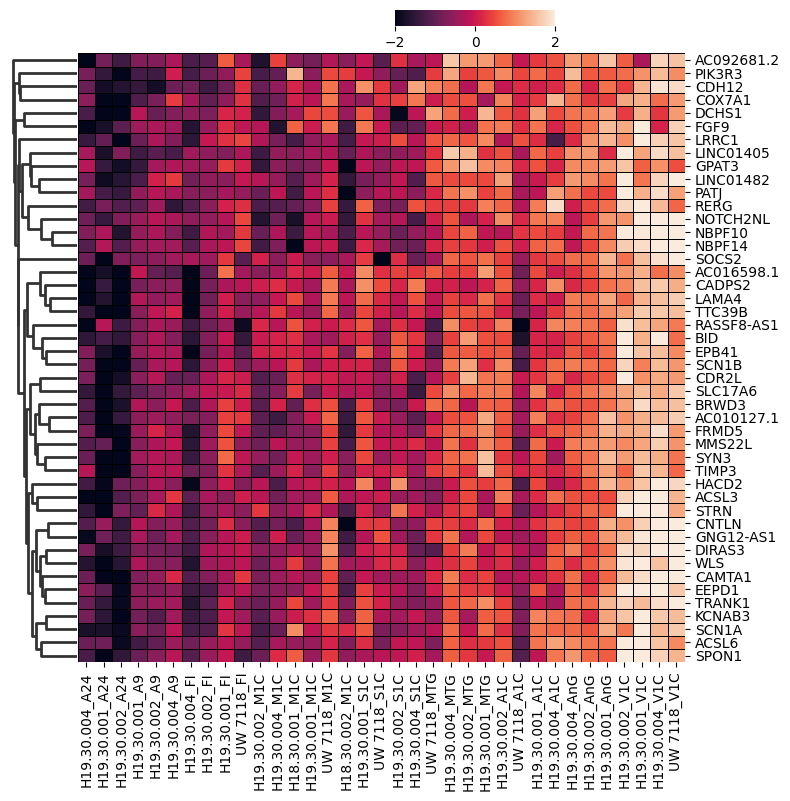

In [15]:
fig = sns.clustermap(
    positive_matrix.T,
    xticklabels=sorted_index.to_list(),
    yticklabels=positive_sig_genes,
    z_score="row",
    figsize=(8, 8),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=0.5,
    linecolor="black",
    vmin=-2,
    vmax=2
)
fig.savefig(plot_dir / "L4_IT_corr_donor_replicate_positive_RNA.png", dpi=300, format="png")

In [16]:
negative_sig_genes = spearman_sig_negative["gene"].to_list()
negative_matrix = L4_IT_rna_region_counts[sorted_index, negative_sig_genes].X

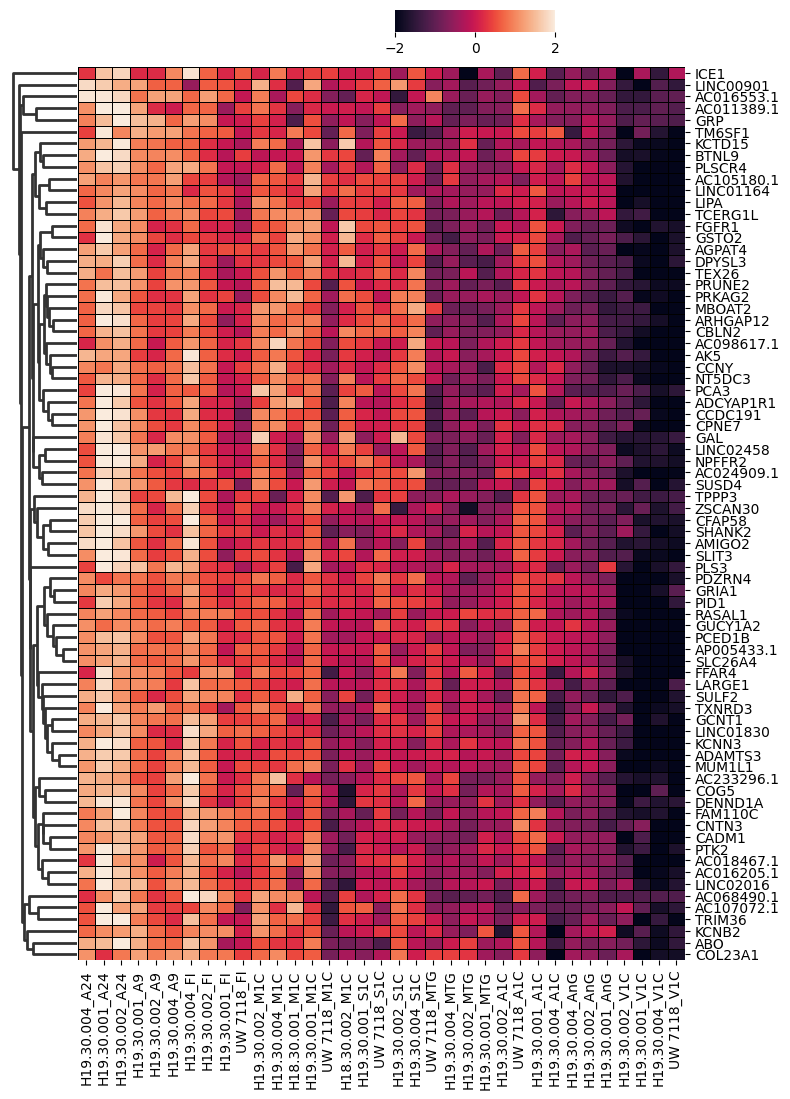

In [17]:
fig = sns.clustermap(
    negative_matrix.T,
    xticklabels=sorted_index.to_list(),
    yticklabels=negative_sig_genes,
    z_score="row",
    figsize=(8, 11),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=0.5,
    linecolor="black",
    vmin=-2,
    vmax=2
)
fig.savefig(plot_dir / "L4_IT_corr_donor_replicate_negative_RNA.png", dpi=300, format="png")

In [18]:
positive_sig_genes = spearman_result[
    (spearman_result["corr"] > 0.7) & (spearman_result["p_adjusted"] < 0.01)]["gene"].to_list()
with open("rostral_caudal_spearman/positive_genes_bh_7e-1_1e-2_donor_replicate.tsv", "w") as fout:
    for gene in positive_sig_genes:
        fout.write("{}\n".format(gene))

positive_sig_genes = spearman_result[
    (spearman_result["corr"] > 0.7) & (spearman_result["p_adjusted"] < 0.05)]["gene"].to_list()
with open("rostral_caudal_spearman/positive_genes_bh_7e-1_5e-2_donor_replicate.tsv", "w") as fout:
    for gene in positive_sig_genes:
        fout.write("{}\n".format(gene))

In [19]:
negative_sig_genes = spearman_result[
    (spearman_result["corr"] < -0.7) & (spearman_result["p_adjusted"] < 0.01)]["gene"].to_list()
with open("rostral_caudal_spearman/negative_genes_bh_7e-1_1e-2_donor_replicate.tsv", "w") as fout:
    for gene in negative_sig_genes:
        fout.write("{}\n".format(gene))

negative_sig_genes = spearman_result[
    (spearman_result["corr"] < -0.7) & (spearman_result["p_adjusted"] < 0.05)]["gene"].to_list()
with open("rostral_caudal_spearman/negative_genes_bh_7e-1_5e-2_donor_replicate.tsv", "w") as fout:
    for gene in negative_sig_genes:
        fout.write("{}\n".format(gene))

In [20]:
full_gene = spearman_result["gene"].to_list()
with open("rostral_caudal_spearman/full_gene_list.tsv", "w") as fout:
    for gene in full_gene:
        fout.write("{}\n".format(gene))

## ATAC spearman / donor as replicates

In [3]:
L4_IT_atac = sc.read_h5ad("L4_IT_atac_matrix.h5ad")

In [4]:
L4_IT_atac.obs["Donor_Region"] = \
    L4_IT_atac.obs["PatientID"].astype("str") + "_" + L4_IT_atac.obs["Region"].astype("str")

In [5]:
L4_IT_atac_region_counts = dc.get_pseudobulk(
    adata=L4_IT_atac,
    sample_col="Donor_Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)

In [6]:
sc.pp.normalize_total(L4_IT_atac_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_atac_region_counts, base=2)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
L4_IT_atac_region_counts.obs["Region"] = pd.Categorical(
    L4_IT_atac_region_counts.obs["Region"], categories=region_align
)

In [8]:
sorted_index = L4_IT_atac_region_counts.obs.sort_values(by="Region").index

In [9]:
b = L4_IT_atac_region_counts.obs.loc[sorted_index, "Region"].cat.codes.to_list()
data_matrix = L4_IT_atac_region_counts[sorted_index, :].X
corrs = np.zeros(data_matrix.shape[1])
pvalues = np.zeros(data_matrix.shape[1])

for i in range(0, data_matrix.shape[1]):
    a = data_matrix[:, i]
    corr, pvalue = stats.spearmanr(a, b)
    corrs[i] = corr
    pvalues[i] = pvalue

In [10]:
padjusted = stats.false_discovery_control(pvalues, method="bh")

In [11]:
spearman_result = pd.DataFrame({
    "region": L4_IT_atac_region_counts.var.index.to_list(),
    "corr": corrs,
    "p_value": pvalues,
    "p_adjusted": padjusted,
})

In [12]:
spearman_result.to_csv(
    "L4_IT_atac_rostral_caudal_spearman_corr_with_donor_replicates.tsv", sep="\t", header=True, index=False)

In [13]:
spearman_sig_positive = spearman_result[
    (spearman_result["p_adjusted"] < 0.01) & (spearman_result["corr"] > 0.5)]
spearman_sig_negative = spearman_result[
    (spearman_result["p_adjusted"] < 0.01) & (spearman_result["corr"] < -0.5)]

In [14]:
positive_sig_regions = spearman_sig_positive["region"].to_list()
positive_matrix = L4_IT_atac_region_counts[sorted_index, positive_sig_regions].X

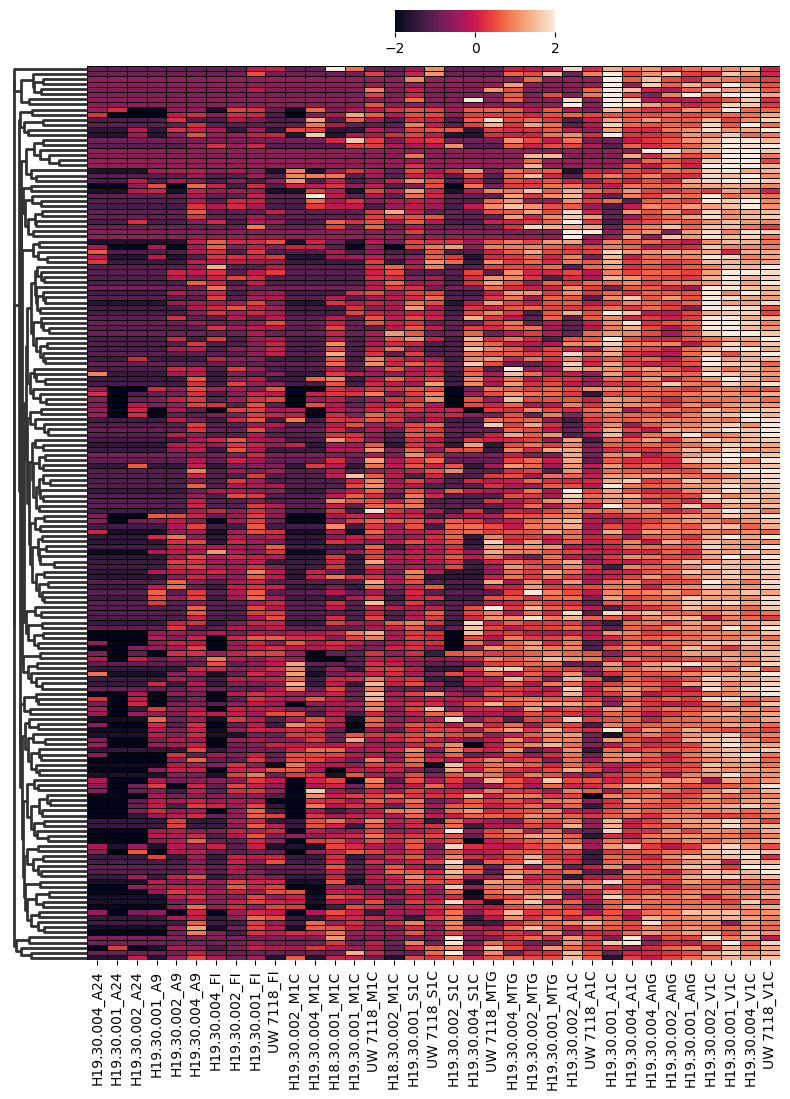

In [15]:
sns.clustermap(
    positive_matrix.T,
    xticklabels=sorted_index.to_list(),
    yticklabels=[],
    z_score="row",
    figsize=(8, 11),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=0.5,
    linecolor="black",
    vmin=-2,
    vmax=2
)

In [16]:
negative_sig_regions = spearman_sig_negative["region"].to_list()
negative_matrix = L4_IT_atac_region_counts[sorted_index, negative_sig_regions].X

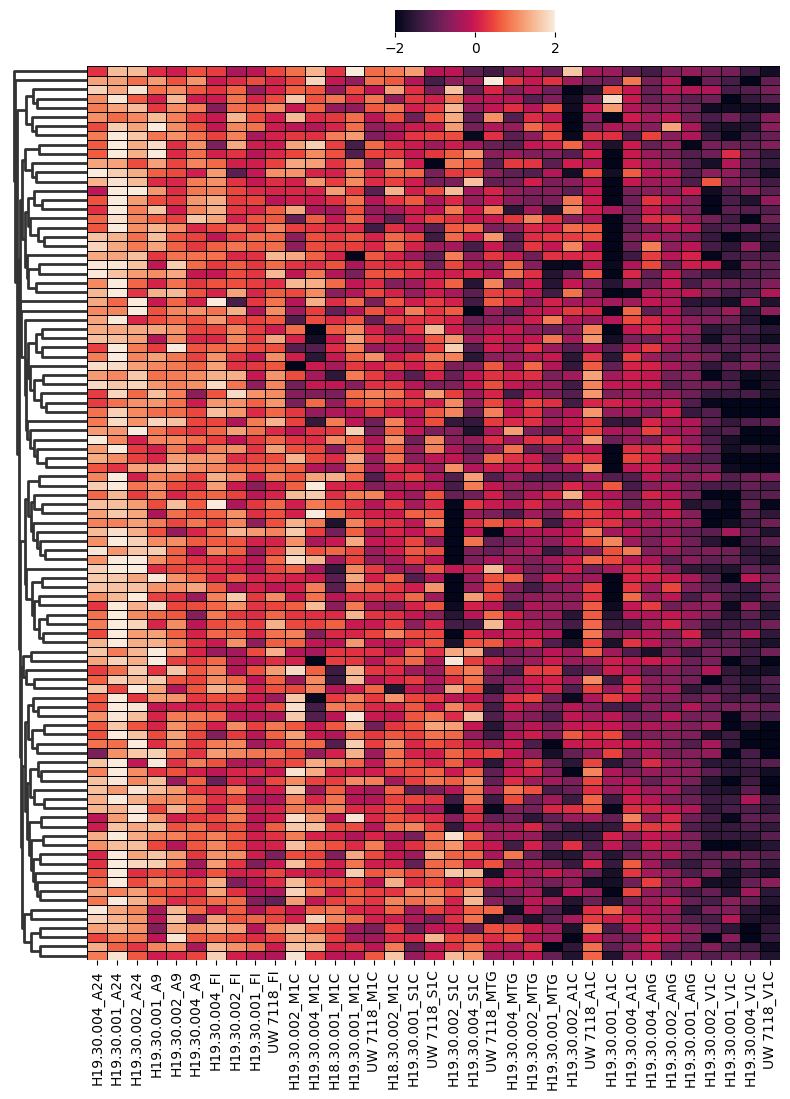

In [17]:
sns.clustermap(
    negative_matrix.T,
    xticklabels=sorted_index.to_list(),
    yticklabels=[],
    z_score="row",
    figsize=(8, 11),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=0.5,
    linecolor="black",
    vmin=-2,
    vmax=2
)

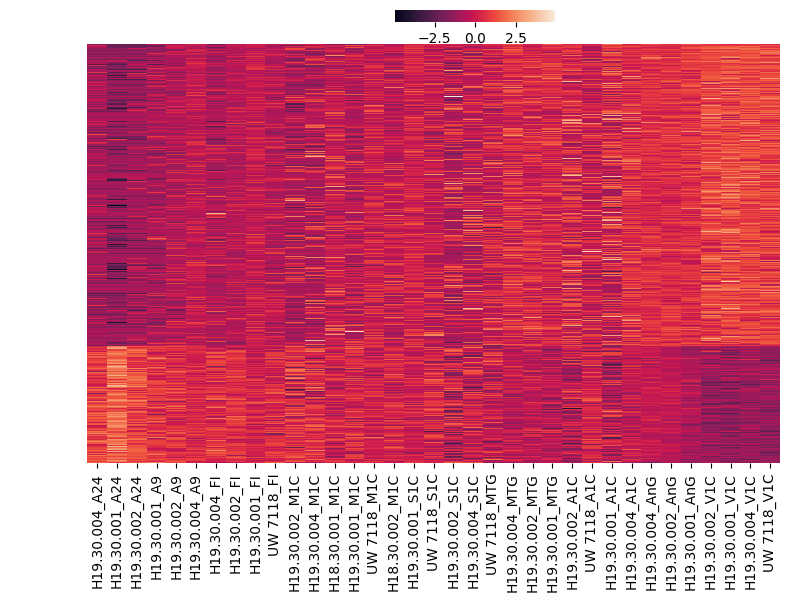

In [21]:
full_region = spearman_result[spearman_result["p_adjusted"] < 0.05].sort_values(
    by="corr", ascending=False)["region"]
full_sorted_matrix = L4_IT_atac_region_counts[sorted_index, full_region].X
fig = sns.clustermap(
    full_sorted_matrix.T,
    xticklabels=sorted_index.to_list(),
    yticklabels=[],
    z_score="row",
    figsize=(8, 6),
    col_cluster=False,
    row_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    # tree_kws={"linewidth": 2},
    # linewidth=0.5,
    # linecolor="black",
)
fig.savefig(plot_dir / "L4_IT_rostral_caudal_corr_ATAC.png", dpi=300, format="png")

In [21]:
positive_sig_regions = spearman_result[
    (spearman_result["corr"] > 0.5) & (spearman_result["p_adjusted"] < 0.01)]["region"].to_list()
with open("rostral_caudal_spearman/positive_peaks_bh_5e-1_1e-2_donor_replicate.tsv", "w") as fout:
    for region in positive_sig_regions:
        fout.write("{}\n".format(region))
with open("rostral_caudal_spearman/positive_peaks_bh_5e-1_1e-2_donor_replicate.bed", "w") as fout:
    for index, region in enumerate(positive_sig_regions):
        chromosome, start, end = region.split("-")
        fout.write("{}\t{}\t{}\tpositive_{}\t100\t+\n".format(chromosome, start, end, index))

positive_sig_regions = spearman_result[
    (spearman_result["corr"] > 0.5) & (spearman_result["p_adjusted"] < 0.05)]["region"].to_list()
with open("rostral_caudal_spearman/positive_peaks_bh_5e-1_5e-2_donor_replicate.tsv", "w") as fout:
    for region in positive_sig_regions:
        fout.write("{}\n".format(region))
with open("rostral_caudal_spearman/positive_peaks_bh_5e-1_5e-2_donor_replicate.bed", "w") as fout:
    for index, region in enumerate(positive_sig_regions):
        chromosome, start, end = region.split("-")
        fout.write("{}\t{}\t{}\tpositive_{}\t100\t+\n".format(chromosome, start, end, index))

In [22]:
negative_sig_regions = spearman_result[
    (spearman_result["corr"] < -0.5) & (spearman_result["p_adjusted"] < 0.01)]["region"].to_list()
with open("rostral_caudal_spearman/negative_peaks_bh_5e-1_1e-2_donor_replicate.tsv", "w") as fout:
    for region in negative_sig_regions:
        fout.write("{}\n".format(region))
with open("rostral_caudal_spearman/negative_peaks_bh_5e-1_1e-2_donor_replicate.bed", "w") as fout:
    for index, region in enumerate(negative_sig_regions):
        chromosome, start, end = region.split("-")
        fout.write("{}\t{}\t{}\tnegative_{}\t100\t+\n".format(chromosome, start, end, index))

negative_sig_regions = spearman_result[
    (spearman_result["corr"] < -0.5) & (spearman_result["p_adjusted"] < 0.05)]["region"].to_list()
with open("rostral_caudal_spearman/negative_peaks_bh_5e-1_5e-2_donor_replicate.tsv", "w") as fout:
    for region in negative_sig_regions:
        fout.write("{}\n".format(region))
with open("rostral_caudal_spearman/negative_peaks_bh_5e-1_5e-2_donor_replicate.bed", "w") as fout:
    for index, region in enumerate(negative_sig_regions):
        chromosome, start, end = region.split("-")
        fout.write("{}\t{}\t{}\tnegative_{}\t100\t+\n".format(chromosome, start, end, index))

#### Inspect the enriched motifs

In [3]:
homer2_motif_dict = pd.read_csv(
    "/tscc/projects/ps-epigen/users/biy022/MGH/data/metadata/homer2_motif_database.csv",
    sep=",", header=0
)

In [4]:
L4_IT_rna = sc.read_h5ad("L4_IT_rna_matrix.h5ad")
L4_IT_rna_counts = L4_IT_rna.raw.to_adata()
L4_IT_rna_counts.obs["Donor_Region"] = \
    L4_IT_rna_counts.obs["PatientID"].astype("str") + "_" + L4_IT_rna_counts.obs["Region"].astype("str")
L4_IT_rna_region_counts = dc.get_pseudobulk(
    adata=L4_IT_rna_counts,
    sample_col="Donor_Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(L4_IT_rna_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
L4_IT_rna_region_counts.obs["Region"] = pd.Categorical(
    L4_IT_rna_region_counts.obs["Region"], categories=region_align
)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
sorted_index = L4_IT_rna_region_counts.obs.sort_values(by="Region").index

In [6]:
positive_table = pd.read_csv(
    "rostral_caudal_spearman/peaks_bh_5e-1_5e-2_donor_replicate/positive_correlation/knownResults.txt",
    sep="\t", header=0
)
positive_tfs_table = pd.merge(
    positive_table,
    homer2_motif_dict,
    left_on="Motif Name",
    right_on="motif_names",
    how="inner"
)
positive_tfs_table = positive_tfs_table[~pd.isna(positive_tfs_table["tfs"])]
positive_sig_tfs = positive_tfs_table[positive_tfs_table["q-value (Benjamini)"] < 0.01]["tfs"]

In [7]:
positive_sig_tfs = positive_sig_tfs[positive_sig_tfs.isin(L4_IT_rna_region_counts.var.index)]
positive_matrix = L4_IT_rna_region_counts[sorted_index, positive_sig_tfs.to_list()].X

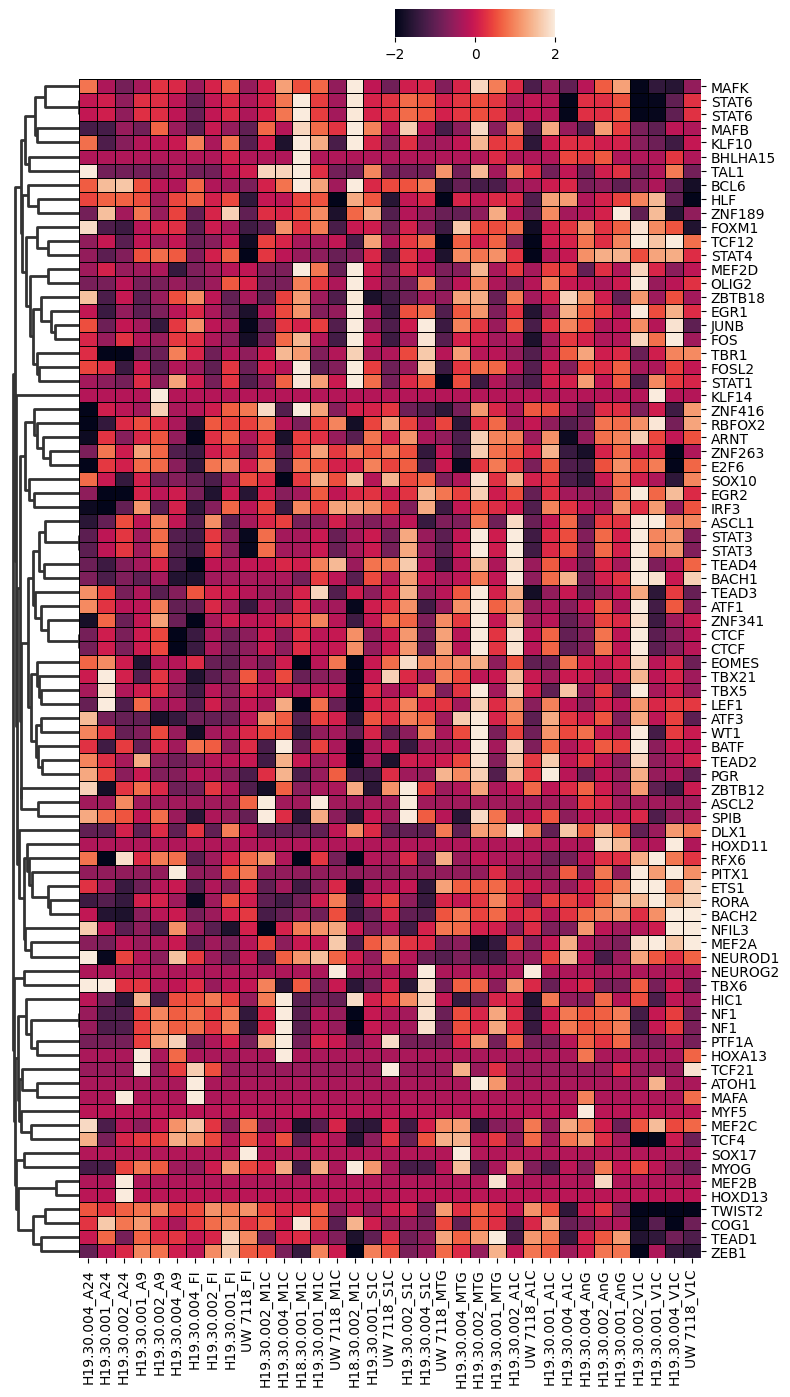

In [8]:
sns.clustermap(
    positive_matrix.T,
    xticklabels=sorted_index.to_list(),
    yticklabels=positive_sig_tfs,
    z_score="row",
    figsize=(8, 14),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=0.5,
    linecolor="black",
    vmin=-2,
    vmax=2
)

In [9]:
L4_IT_rna = sc.read_h5ad("L4_IT_rna_matrix.h5ad")
L4_IT_rna_counts = L4_IT_rna.raw.to_adata()
L4_IT_rna_region_counts = dc.get_pseudobulk(
    adata=L4_IT_rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(L4_IT_rna_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
L4_IT_rna_region_counts.obs["Region"] = pd.Categorical(
    L4_IT_rna_region_counts.obs["Region"], categories=region_align
)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
positive_matrix = L4_IT_rna_region_counts[region_align, positive_sig_tfs.to_list()].X

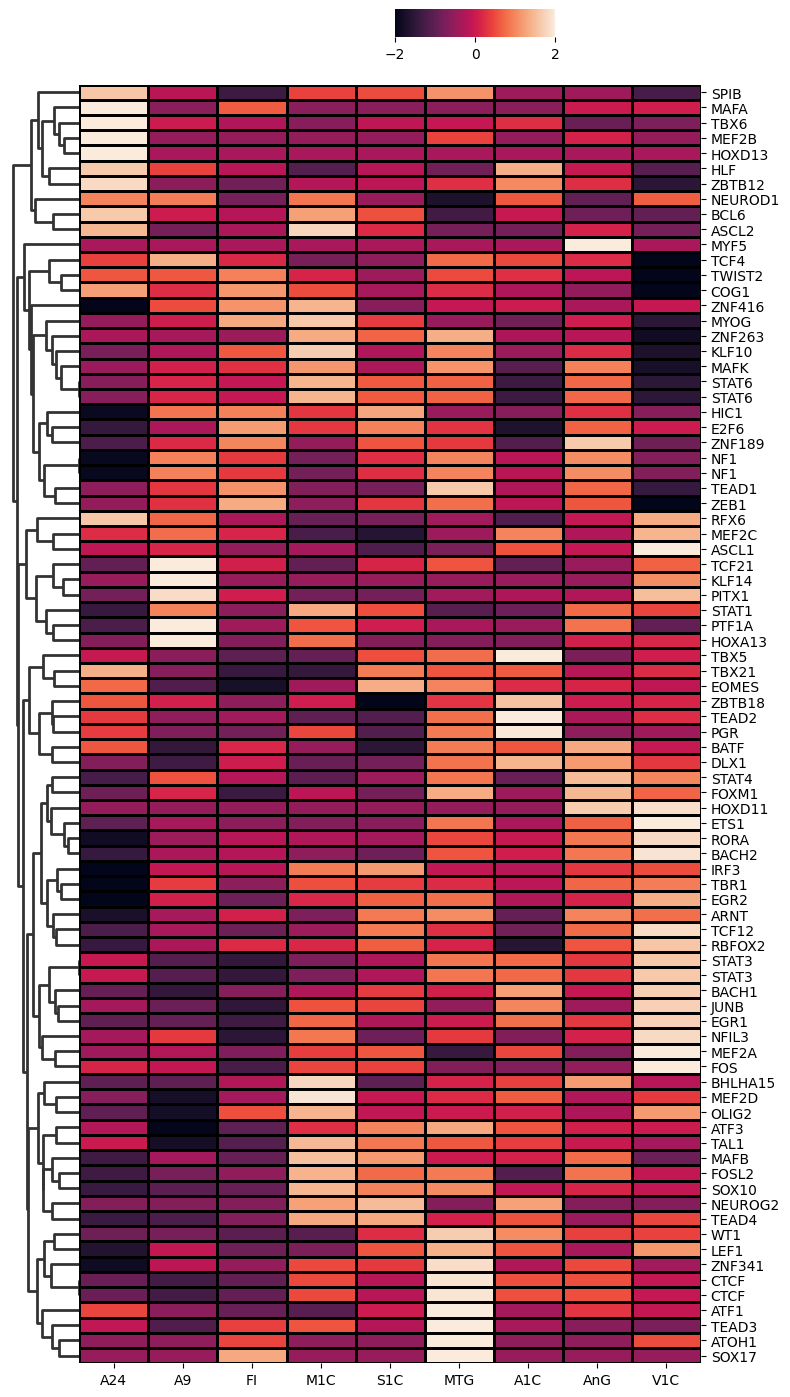

In [11]:
sns.clustermap(
    positive_matrix.T,
    xticklabels=region_align,
    yticklabels=positive_sig_tfs,
    z_score="row",
    figsize=(8, 14),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=1,
    linecolor="black",
    vmin=-2,
    vmax=2
)

In [12]:
L4_IT_rna = sc.read_h5ad("L4_IT_rna_matrix.h5ad")
L4_IT_rna_counts = L4_IT_rna.raw.to_adata()
L4_IT_rna_counts.obs["Donor_Region"] = \
    L4_IT_rna_counts.obs["PatientID"].astype("str") + "_" + L4_IT_rna_counts.obs["Region"].astype("str")
L4_IT_rna_region_counts = dc.get_pseudobulk(
    adata=L4_IT_rna_counts,
    sample_col="Donor_Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(L4_IT_rna_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
L4_IT_rna_region_counts.obs["Region"] = pd.Categorical(
    L4_IT_rna_region_counts.obs["Region"], categories=region_align
)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
sorted_index = L4_IT_rna_region_counts.obs.sort_values(by="Region").index

In [14]:
negative_table = pd.read_csv(
    "rostral_caudal_spearman/peaks_bh_5e-1_5e-2_donor_replicate/negative_correlation/knownResults.txt",
    sep="\t", header=0
)
negative_tfs_table = pd.merge(
    negative_table,
    homer2_motif_dict,
    left_on="Motif Name",
    right_on="motif_names",
    how="inner"
)
negative_tfs_table = negative_tfs_table[~pd.isna(negative_tfs_table["tfs"])]
negative_sig_tfs = negative_tfs_table[negative_tfs_table["q-value (Benjamini)"] < 0.01]["tfs"]

In [15]:
negative_sig_tfs = negative_sig_tfs[negative_sig_tfs.isin(L4_IT_rna_region_counts.var.index)]
negative_matrix = L4_IT_rna_region_counts[sorted_index, negative_sig_tfs.to_list()].X

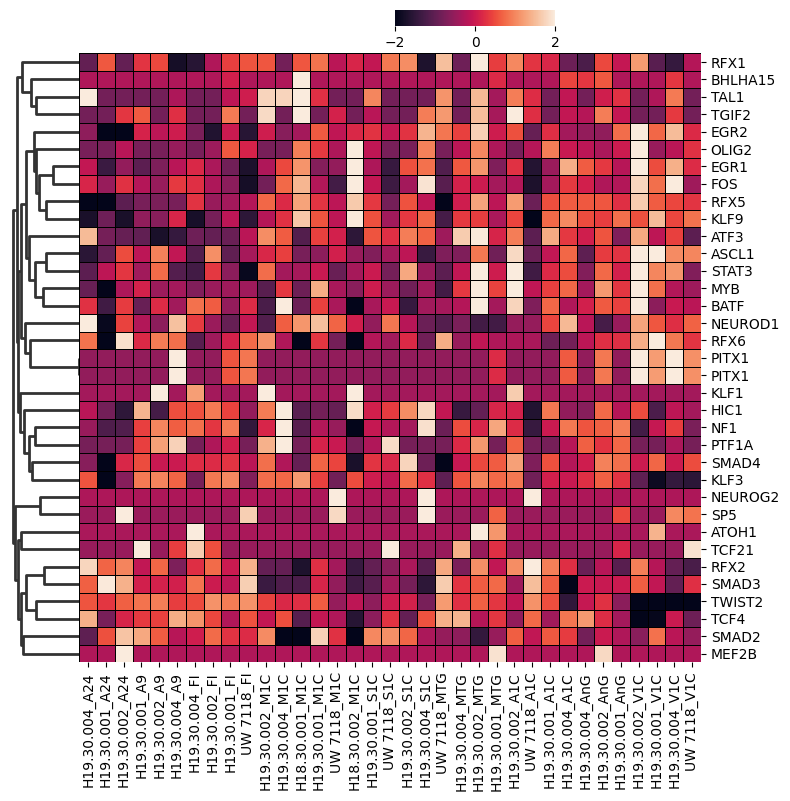

In [16]:
sns.clustermap(
    negative_matrix.T,
    xticklabels=sorted_index.to_list(),
    yticklabels=negative_sig_tfs,
    z_score="row",
    figsize=(8, 8),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=0.5,
    linecolor="black",
    vmin=-2,
    vmax=2
)

In [17]:
L4_IT_rna = sc.read_h5ad("L4_IT_rna_matrix.h5ad")
L4_IT_rna_counts = L4_IT_rna.raw.to_adata()
L4_IT_rna_region_counts = dc.get_pseudobulk(
    adata=L4_IT_rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(L4_IT_rna_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
L4_IT_rna_region_counts.obs["Region"] = pd.Categorical(
    L4_IT_rna_region_counts.obs["Region"], categories=region_align
)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
negative_matrix = L4_IT_rna_region_counts[region_align, negative_sig_tfs.to_list()].X

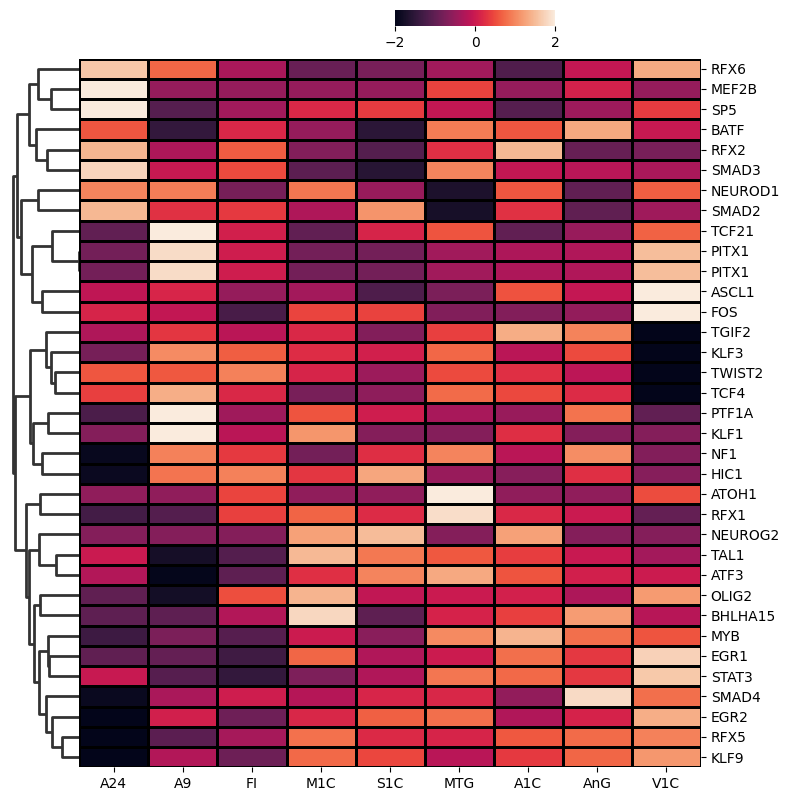

In [19]:
sns.clustermap(
    negative_matrix.T,
    xticklabels=region_align,
    yticklabels=negative_sig_tfs,
    z_score="row",
    figsize=(8, 8),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=1,
    linecolor="black",
    vmin=-2,
    vmax=2
)

#### List of TFs to check inidvidually by Homer2

In [3]:
L4_IT_rna = sc.read_h5ad("L4_IT_rna_matrix.h5ad")
L4_IT_rna_counts = L4_IT_rna.raw.to_adata()
L4_IT_rna_counts.obs["Donor_Region"] = \
    L4_IT_rna_counts.obs["PatientID"].astype("str") + "_" + L4_IT_rna_counts.obs["Region"].astype("str")
L4_IT_rna_region_counts = dc.get_pseudobulk(
    adata=L4_IT_rna_counts,
    sample_col="Donor_Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(L4_IT_rna_region_counts, target_sum=1e6)
sc.pp.log1p(L4_IT_rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
L4_IT_rna_region_counts.obs["Region"] = pd.Categorical(
    L4_IT_rna_region_counts.obs["Region"], categories=region_align
)
sorted_index = L4_IT_rna_region_counts.obs.sort_values(by="Region").index

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
tf_list = [
    "ETS1", "ELF2", "JDP2", "TCF12", "PLAGL1", "KLF12", "ETS2", "ETV5",
    "KLF6", "RORA", "ARNTL", "NFIB", "NR2F1", "LHX2", "BACH2", "NFIX"
]

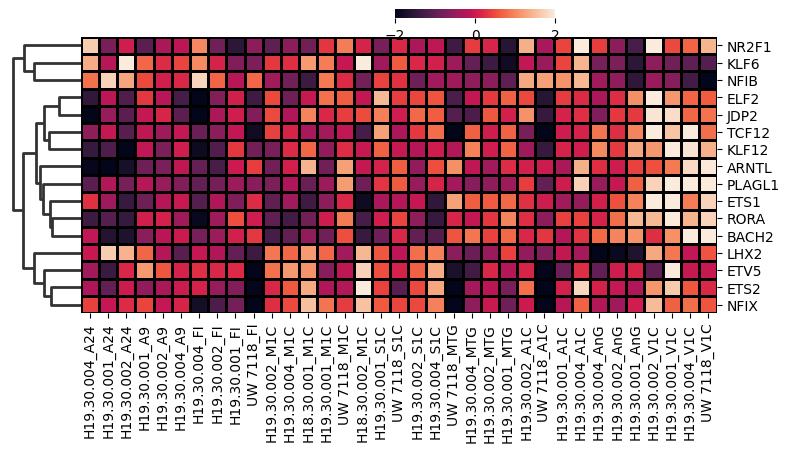

In [5]:
tf_matrix = L4_IT_rna_region_counts[sorted_index, tf_list].X
fig = sns.clustermap(
    tf_matrix.T,
    xticklabels=sorted_index.to_list(),
    yticklabels=tf_list,
    z_score="row",
    figsize=(8, 4.5),
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    tree_kws={"linewidth": 2},
    linewidth=1,
    linecolor="black",
    vmin=-2,
    vmax=2
)
fig.savefig(
    plot_dir / "L4_IT_corr_donor_replicate_ATAC_selected_TFs.png",
    dpi=300, format="png"
)

In [6]:
# Plot the p-values of the enriched motifs
result_dir = Path("rostral_caudal_spearman/peaks_bh_5e-1_5e-2_donor_replicate_selected_tfs")
positive_pvalues = pd.read_csv(
    result_dir / "positive_correlation/knownResults.txt",
    header=0, sep="\t"
)
positive_pvalues.columns = [
    "motif", "consensus", "pvalue", "logp", "qvalue", "ntarget",
    "prop_target", "nbg", "prop_bg"
]
positive_pvalues["label"] = "positive"
negative_pvalues = pd.read_csv(
    result_dir / "negative_correlation/knownResults.txt",
    header=0, sep="\t"
)
negative_pvalues.columns = [
    "motif", "consensus", "pvalue", "logp", "qvalue", "ntarget",
    "prop_target", "nbg", "prop_bg"
]
negative_pvalues["label"] = "negative"
combined_pvalues = pd.concat(
    [positive_pvalues, negative_pvalues],
    axis="index"
)

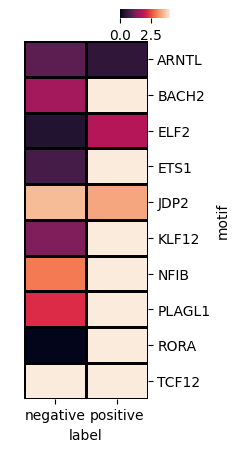

In [7]:
plot_matrix = combined_pvalues.pivot(index="motif", columns="label", values="logp")
fig = sns.clustermap(
    -plot_matrix / np.log(10),
    # xticklabels=sorted_index.to_list(),
    # yticklabels=tf_list,
    # z_score="row",
    figsize=(2.5, 4.5),
    col_cluster=False,
    row_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.5, 0.975, 0.2, 0.02),
    cbar_kws={"orientation": "horizontal"},
    linewidth=1.0,
    linecolor="black",
    vmin=0,
    vmax=4
)
fig.savefig(
    plot_dir / "L4_IT_corr_positive_enriched_selected_TFs.png",
    dpi=300, format="png"
)

In [8]:
regulon_direct_table = pd.read_csv(
    "scplus_outputs/eRegulon_direct.tsv",
    sep="\t", header=0
)
regulon_extended_table = pd.read_csv(
    "scplus_outputs/eRegulons_extended.tsv",
    sep="\t", header=0
)

In [9]:
def plot_target_genes(regulon, regulon_table, figheight, filename):
    curr_table = regulon_table.loc[regulon_table["Gene_signature_name"] == regulon, :]
    if curr_table.shape[0] <= 0:
        return
    target_gene_list = curr_table["Gene"].to_list()
    target_gene_list = list(set(target_gene_list))

    fig = sns.clustermap(
        L4_IT_rna_region_counts[sorted_index, target_gene_list].X.T,
        xticklabels=sorted_index.to_list(),
        yticklabels=target_gene_list,
        z_score="row",
        figsize=(8, figheight),
        col_cluster=False,
        dendrogram_ratio=(0.1, 0.05),
        cbar_pos=(0.5, 0.975, 0.2, 0.02),
        cbar_kws={"orientation": "horizontal"},
        tree_kws={"linewidth": 2},
        linewidth=1,
        linecolor="black",
        vmin=-2,
        vmax=2
    )
    fig.savefig(
        plot_dir / filename,
        dpi=300, format="png"
    )

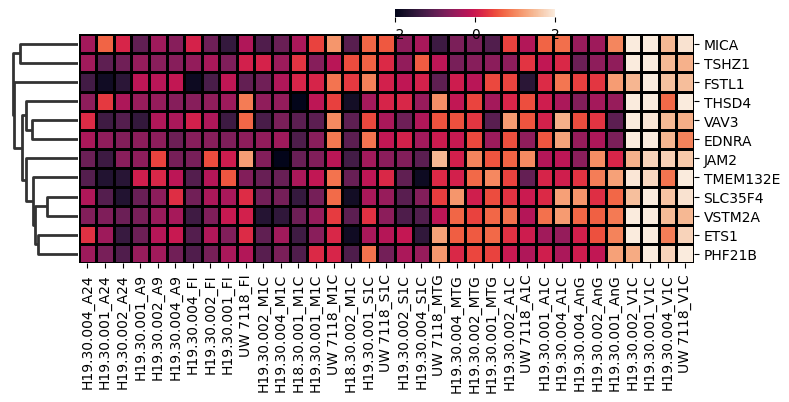

In [10]:
plot_target_genes(
    "ETS1_direct_+/+_(12g)", regulon_direct_table, 4,
    "L4_IT_ETS1_direct_activator_target_donor_replicate_RNA.png"
)

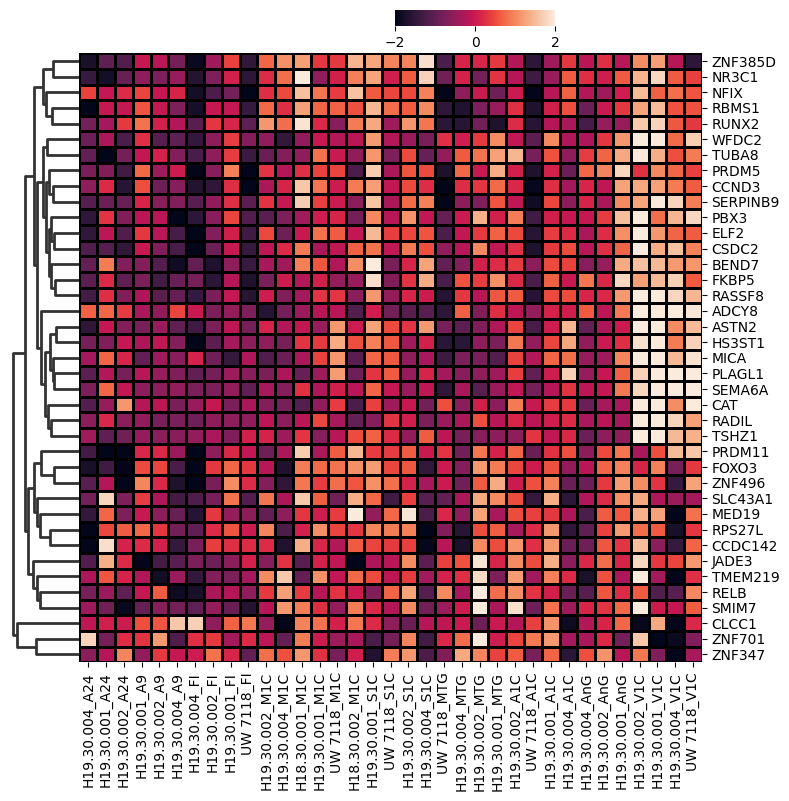

In [11]:
plot_target_genes(
    "ELF2_direct_+/+_(39g)", regulon_direct_table, 8,
    "L4_IT_ELF2_direct_activator_target_donor_replicate_RNA.png"
)

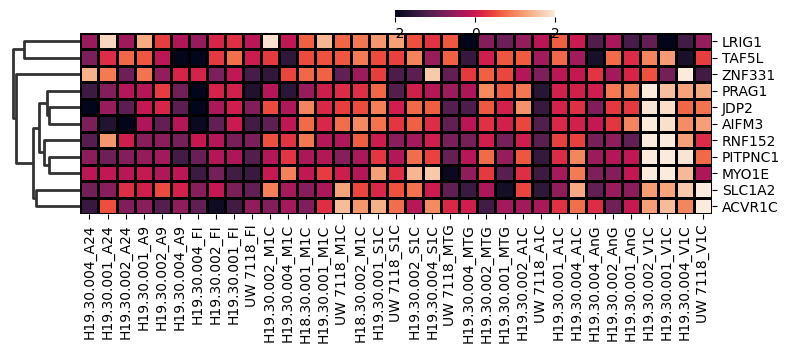

In [12]:
plot_target_genes(
    "JDP2_extended_+/+_(11g)", regulon_extended_table, 3.5,
    "L4_IT_JDP2_extended_activator_target_donor_replicate_RNA.png"
)

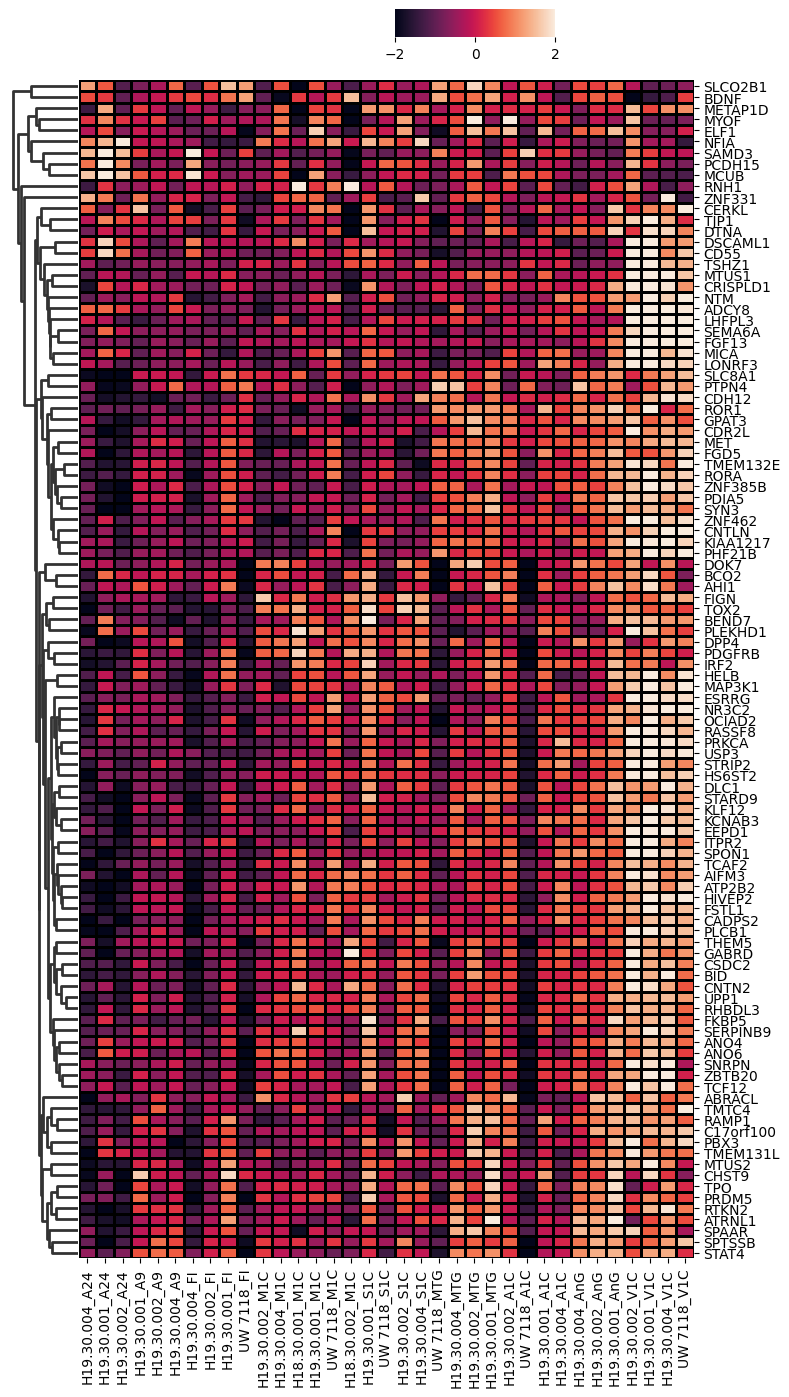

In [13]:
plot_target_genes(
    "TCF12_direct_+/+_(106g)", regulon_direct_table, 14,
    "L4_IT_TCF12_direct_activator_target_donor_replicate_RNA.png"
)

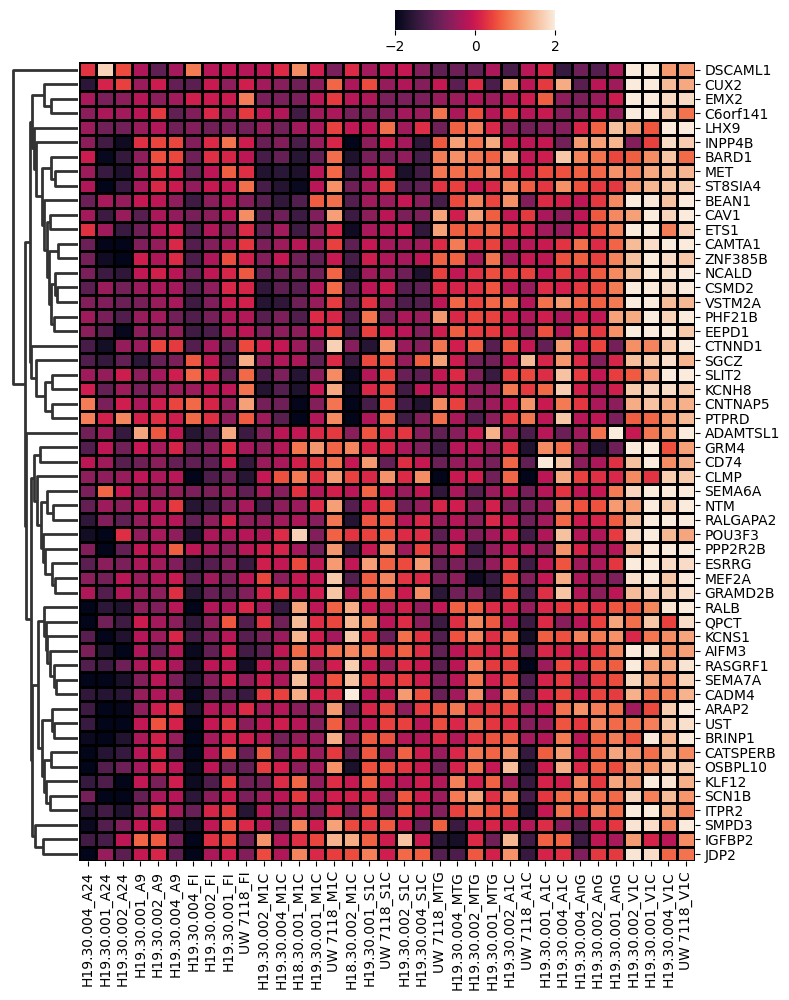

In [14]:
plot_target_genes(
    "PLAGL1_extended_+/+_(55g)", regulon_extended_table, 10,
    "L4_IT_PLAGL1_extended_activator_target_donor_replicate_RNA.png"
)

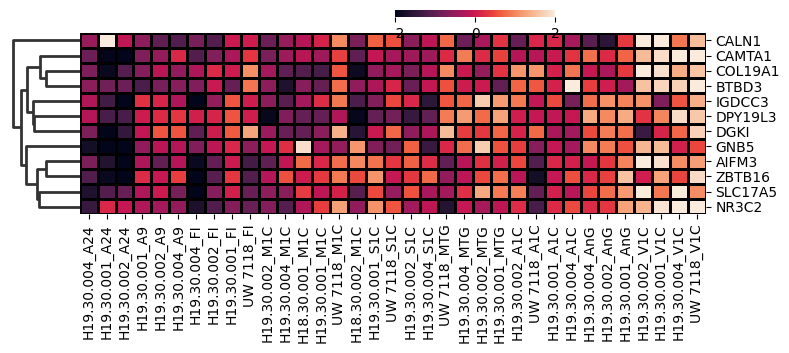

In [15]:
plot_target_genes(
    "RORA_direct_+/+_(12g)", regulon_direct_table, 3.5,
    "L4_IT_RORA_direct_activator_target_donor_replicate_RNA.png"
)

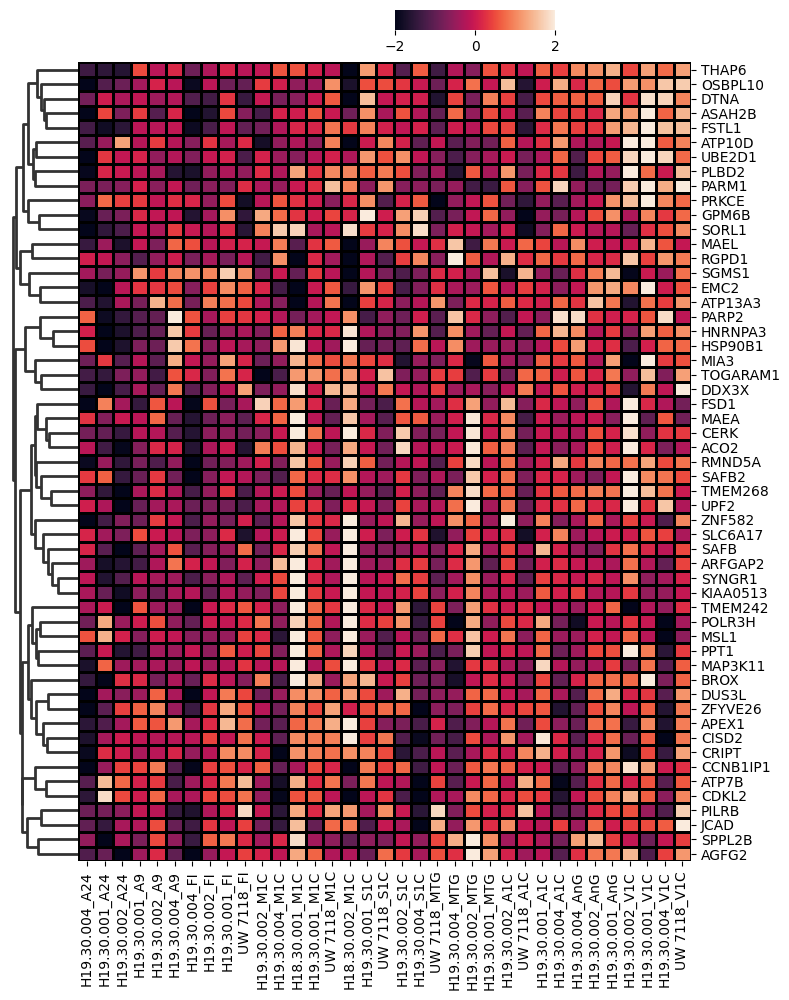

In [17]:
plot_target_genes(
    "ARNTL_direct_+/+_(55g)", regulon_direct_table, 10,
    "L4_IT_ARNTL_direct_activator_target_donor_replicate_RNA.png"
)

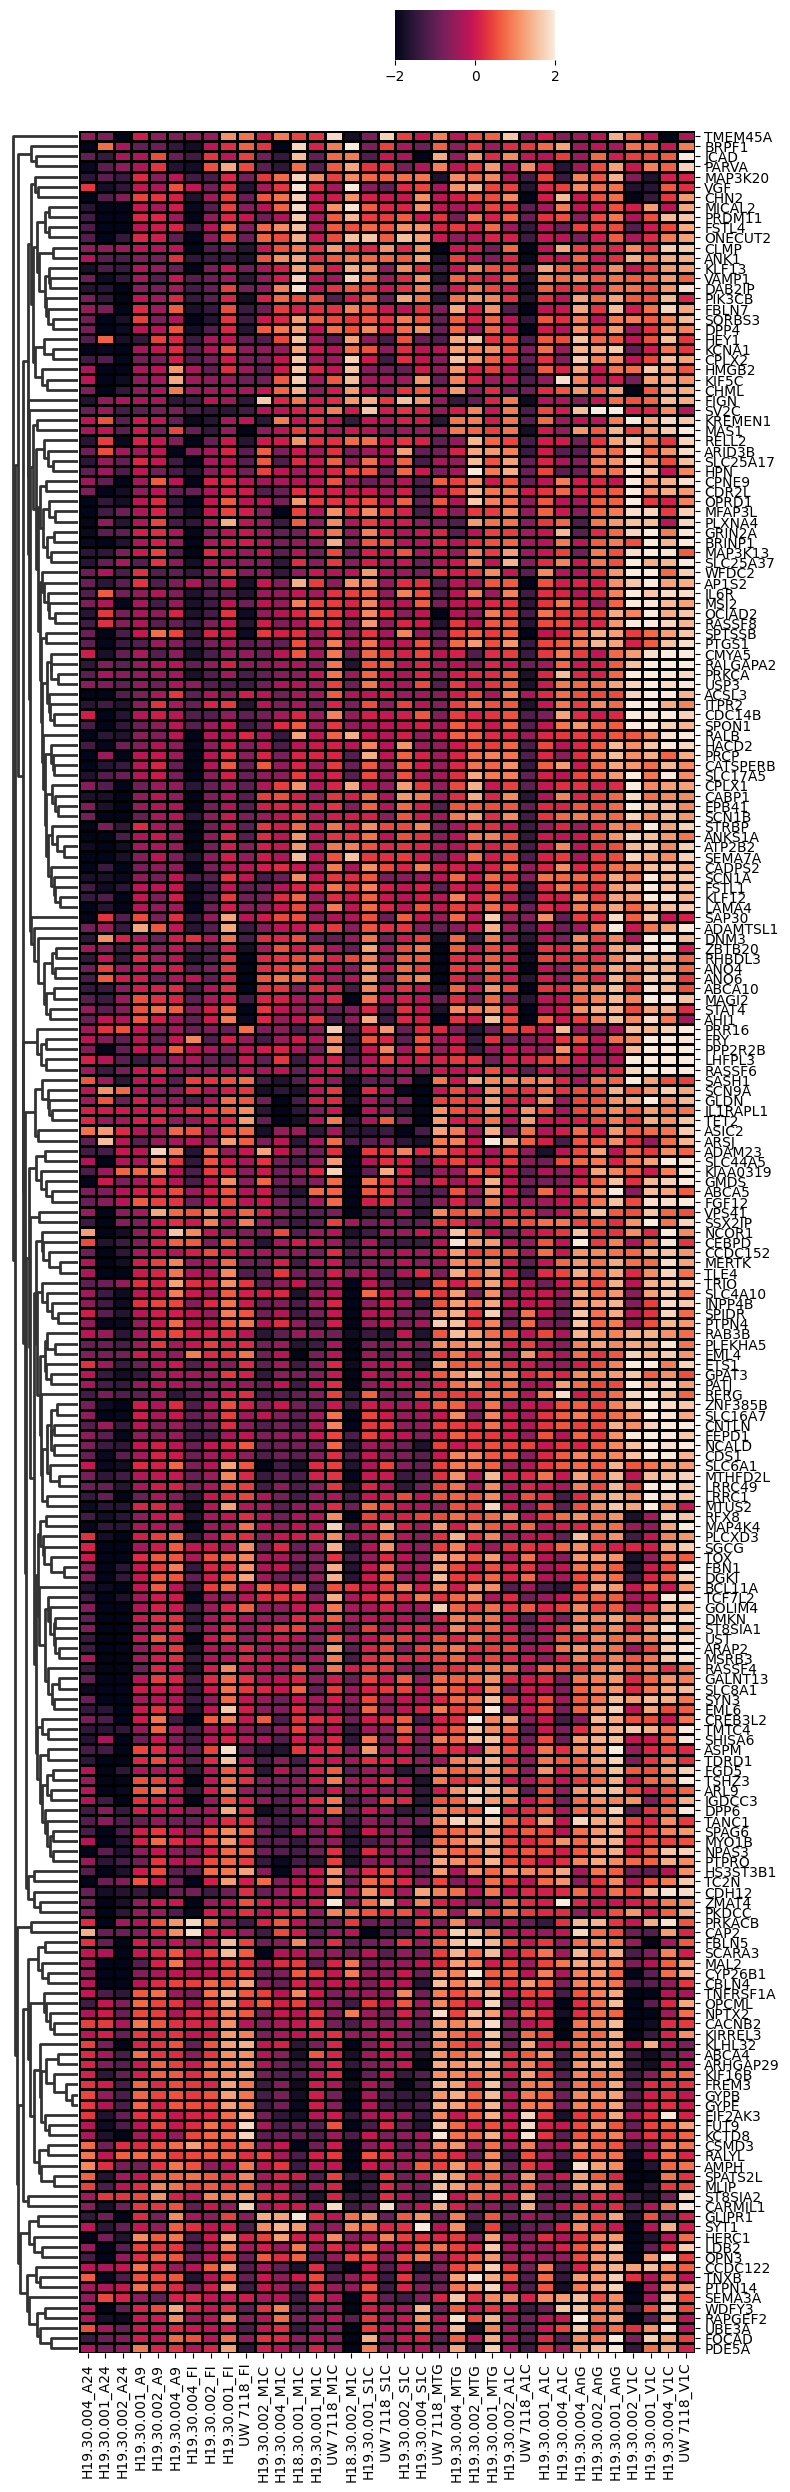

In [18]:
plot_target_genes(
    "BACH2_direct_+/+_(219g)", regulon_direct_table, 25,
    "L4_IT_BACH2_direct_activator_target_donor_replicate_RNA.png"
)

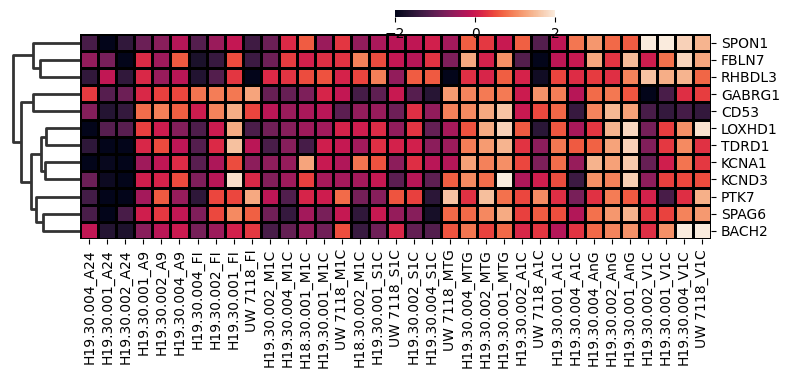

In [19]:
plot_target_genes(
    "NFIB_direct_-/+_(12g)", regulon_direct_table, 3.75,
    "L4_IT_NFIB_direct_repressor_target_donor_replicate_RNA.png"
)